#Анализ данных

##Описание источника

Датасет сформирован из набора фотографий итогов проведение планово-профилактических работ на объектах связи

Извлекались фотографии на которых зафиксирован общий вид мест размещения телекоммуникационных шкафов исключительно в закрытом состоянии, отсальные снимки в расчет не берем

Далее с помощью "написать ПО" по каждой фотографии подготовлены аннотации содержащие
- bounding box в котором присутствуют исследуемые объекты
- описание типа шкафа
- дополнительные признаки

Фотографии размещены в папке images

Аннотации в папке annotations_xml в формате .xml

##Шаг 1: Подготовка среды и загрузка данных

Библиотеки:


In [1]:
import os
import xml.etree.ElementTree as ET
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob

Dataset:

In [2]:
!git clone https://github.com/torpedonosec80/object_foto_dataset.git

Cloning into 'object_foto_dataset'...
remote: Enumerating objects: 11369, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 11369 (delta 63), reused 2 (delta 0), pack-reused 11259 (from 1)
Receiving objects: 100% (11369/11369), 161.30 MiB | 27.22 MiB/s, done.
Resolving deltas: 100% (5683/5683), done.
Updating files: 100% (1909/1909), done.


Структура данных:

проверим количество фотографий и аннотаций к ним

In [3]:
images_dir = '/content/object_foto_dataset/dataset_foto_boxes/images'
annotations_dir = '/content/object_foto_dataset/dataset_foto_boxes/annotations_xml'

image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.jpeg')])
annotation_files = sorted([f for f in os.listdir(annotations_dir) if f.endswith('.xml')])

print(f"Найдено изображений: {len(image_files)}")
print(f"Найдено аннотаций: {len(annotation_files)}")

Найдено изображений: 436
Найдено аннотаций: 436


количество изображений и аннотаций совпадает

*общее количество фотографий не велико, возможность увеличения набора данных будет дополнительной задачей с учетом результатов исследования датасета и появления возможных замечаний*

##Шаг 2: Проверка согласованности данных

In [4]:
# Проверка соответствия имен файлов
image_basenames = {os.path.splitext(f)[0] for f in image_files}
annotation_basenames = {os.path.splitext(f)[0] for f in annotation_files}

missing_images = annotation_basenames - image_basenames
missing_annotations = image_basenames - annotation_basenames

print(f"Аннотации без изображений: {len(missing_images)}")
print(f"Изображения без аннотаций: {len(missing_annotations)}")

Аннотации без изображений: 0
Изображения без аннотаций: 0


для всех фотографий есть аннотации

##Шаг 3: Анализ аннотаций

a) Парсинг XML:

In [10]:
rows = []
anns   = glob(os.path.join(annotations_dir, '*.xml'))
for xml_file in anns:
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Имя изображения
        filename_tag = root.find('filename')
        if filename_tag is None or filename_tag.text is None:
            print(f"[!] Нет имени изображения: {xml_file}")
            continue

        img_name = filename_tag.text.strip()
        img_path = os.path.join(images_dir, img_name)
        if not os.path.exists(img_path):
            print(f"[!] Изображение не найдено: {img_path}")
            continue

        # Получаем размер изображения напрямую
        with Image.open(img_path) as img:
            w, h = img.size

        for obj in root.findall('object'):
            cls = obj.find('name')
            bbox = obj.find('bndbox')
            if cls is None or bbox is None:
                continue

            xmin = bbox.find('xmin')
            ymin = bbox.find('ymin')
            xmax = bbox.find('xmax')
            ymax = bbox.find('ymax')

            if None in (xmin, ymin, xmax, ymax):
                continue

            rows.append({
                'image': img_name,
                'class': cls.text,
                'img_w': w,
                'img_h': h,
                'xmin': int(xmin.text),
                'ymin': int(ymin.text),
                'xmax': int(xmax.text),
                'ymax': int(ymax.text)
            })

    except Exception as e:
        print(f"[!] Ошибка в {xml_file}: {e}")

df = pd.DataFrame(rows)
df['bbox_w'] = df['xmax'] - df['xmin']
df['bbox_h'] = df['ymax'] - df['ymin']
df['bbox_area'] = df['bbox_w'] * df['bbox_h']
print(f"Объектов загружено: {len(df)}")
df.head()


Объектов загружено: 503


image    class  img_w  img_h  xmin  ymin  xmax  ymax  \
0  image_images_0209.jpg   shta-3    960   1280    86   331   808   865   
1  image_images_0267.jpg   shta-3   1024    576   229     4   858   516   
2  image_images_0289.jpg   shta-3   1024    576   164    12   890   560   
3  image_images_0130.jpg  shta-7m    960   1280   302   135   761   453   
4  image_images_0238.jpg   shta-3   1024    576   147    14   775   544   

   bbox_w  bbox_h  bbox_area  
0     722     534     385548  
1     629     512     322048  
2     726     548     397848  
3     459     318     145962  
4     628     530     332840

b) Анализ объектов:



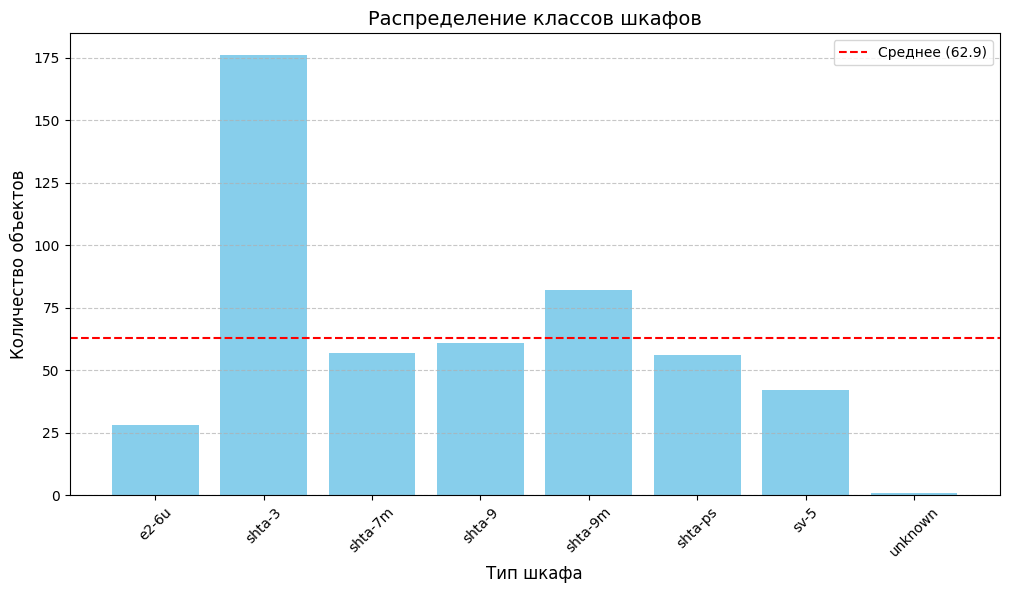

In [12]:
classes = list(df.groupby("class")['image'].agg('count').reset_index()['class'])
counts = list(df.groupby("class")['image'].agg('count').reset_index()['image'])

plt.figure(figsize=(12, 6))
plt.bar(classes, counts, color='skyblue')
plt.axhline(y=sum(counts)/len(counts), color='r', linestyle='--', label=f'Среднее ({sum(counts)/len(counts):.1f})')
plt.title('Распределение классов шкафов', fontsize=14)
plt.xlabel('Тип шкафа', fontsize=12)
plt.ylabel('Количество объектов', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Анализ распределения классов (типов шкафов) говорит о наличии проблем

1. Дисбаланс классов

Классы представлены неравномерно
- Самый частый класс — shta-3 (176 аннотаций, ≈40% от всех)
- Самый редкий — unknown (1 случай), далее e2-6u (28) и sv-5 (42)

Вывод:

Налицо дисбаланс классов, который может негативно повлиять на обучение классификатора

Модель будет склонна переобучаться на более частые классы и "забывать" про редкие.

2. Класс unknown

Это явно либо:

- метка для неопределённых/непонятных объектов
- или ошибка аннотации

Рекомендация:

Проанализировать вручную изображение с меткой unknown.

Решить, стоит ли:
- исключить этот случай
- или переразметить вручную

3. Достаточность данных

Всего 436 объектов — это небольшой объём для глубокого обучения.

Для детекции и особенно классификации может потребоваться:
- аугментация (развороты, изменения яркости, масштаб и т.п.)
- доразметка или сбор новых данных, если возможно

**По итогам анализа распределения классов действия следующие:**
- дополнить датасет фотографиями недостающих классов
- проверить объект "unknown" и либо удалить его из датасета либо скорректировать описание в аннотации

## Шаг 4: Размеры BBox


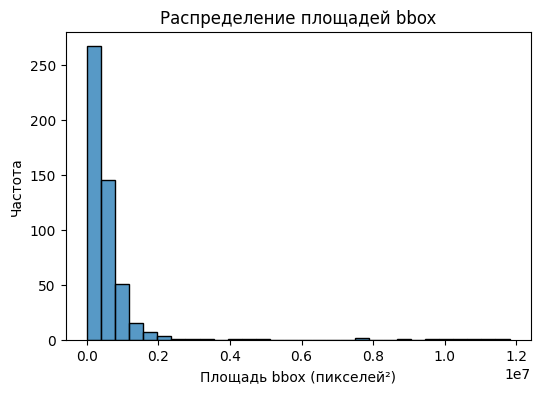

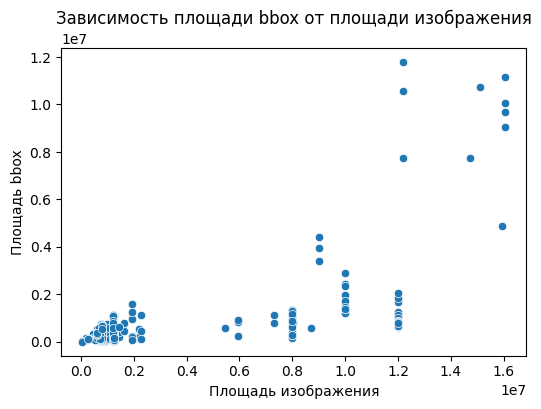

In [14]:
plt.figure(figsize=(6,4))
sns.histplot(df['bbox_area'], bins=30)
plt.title("Распределение площадей bbox")
plt.xlabel("Площадь bbox (пикселей²)")
plt.ylabel("Частота")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x=df['img_w']*df['img_h'], y=df['bbox_area'])
plt.title("Зависимость площади bbox от площади изображения")
plt.xlabel("Площадь изображения")
plt.ylabel("Площадь bbox")
plt.show()


**Что показывает гистограмма:**

Сильная концентрация bbox с малой площадью:
- Подавляющее большинство объектов имеет площадь менее 2 × 10⁶ пикселей²
- Это значит, что объекты в основном небольшие по размеру относительно всего изображения

Длинный правый хвост:
- Есть немного bbox с очень большой площадью (до 10⁷ пикселей²)
- Эти случаи — вероятно, крупные или близко снятые шкафы, либо ошибки аннотаций, где bounding box перекрывает почти всё изображение



**причины разброса:**
- Разный масштаб съёмки (разные расстояния до объекта)
- Разные типы шкафов (размер зависит от модели)
- Частичные аннотации (например, если размечена только часть объекта)



## Шаг 5: Проверка ошибок и аномалий

In [15]:
invalid = df[(df['xmin']<0) | (df['ymin']<0) |
             (df['xmax']>df['img_w']) | (df['ymax']>df['img_h'])]
print("Найдено некорректных bbox:", len(invalid))
small_boxes = df[df['bbox_area']<10]
large_boxes = df[df['bbox_area']>0.9*df['img_w']*df['img_h']]
print("Очень маленьких bbox:", len(small_boxes))
print("Очень больших bbox:", len(large_boxes))

Найдено некорректных bbox: 4
Очень маленьких bbox: 0
Очень больших bbox: 8


1. Некорректные bbox: 4
    
    Это bounding boxes, у которых:
        - xmax <= xmin или ymax <= ymin
        - Отрицательные координаты
    
    Такие объекты невалидны — модель не сможет их использовать корректно.

    ➡️ Вывод:

    Наличие 4 таких bbox говорит о локальных ошибках в разметке. Их нужно исключить или исправить вручную. Возможно, это опечатки при разметке или автоматическая генерация без валидации.

2. Очень маленькие bbox: 0
    Bounding boxes с площадью < допустимого минимума (например, меньше 100 пикселей²).

        Таких не обнаружено — хорошо!

    ➡️ Вывод:

    Объекты размечены так, что они имеют достаточный размер для детекции, и модель не будет "слепа" к ним из-за слишком мелких аннотаций.

3. Очень большие bbox: 8

    Это bbox, занимающие слишком большую часть изображения (например, >90% площади).

    Возможные причины:
        - Действительно крупный шкаф на весь кадр.
        - Ошибочная аннотация (весь кадр размечен как один объект).

    ➡️ Вывод:

    Эти случаи стоит визуально проверить вручную:

        Если это валидные объекты (например, фото сделано вблизи) — можно оставить.

        Если это ошибка (например, bbox полностью покрывает всё фото без нужды) — исправить или удалить.

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image

def show_bbox(df_subset, num_images=5):
    for idx, row in df_subset.head(num_images).iterrows():
        img_path = os.path.join(images_dir, row['image'])
        if not os.path.exists(img_path):
            print(f"Файл не найден: {img_path}")
            continue

        img = Image.open(img_path)
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        rect = patches.Rectangle(
            (row['xmin'], row['ymin']),
            row['xmax'] - row['xmin'],
            row['ymax'] - row['ymin'],
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)

        ax.set_title(f"{row['image']} | class: {row['class']}")
        plt.axis('off')
        plt.show()


In [31]:
invalid

image   class  img_w  img_h  xmin  ymin  xmax  ymax  \
184  image_images_0118.jpg  shta-3   4000   2250   249   981  2030  2894   
200  image_images_0124.jpg  shta-3   4000   2250   110   686  2014  3004   
281  image_images_0123.jpg  shta-3   4000   2250   372   780  2127  3027   
411  image_images_0295.jpg  shta-3   1897   2880   520    -2  1314   715   

     bbox_w  bbox_h  bbox_area  
184    1781    1913    3407053  
200    1904    2318    4413472  
281    1755    2247    3943485  
411     794     717     569298

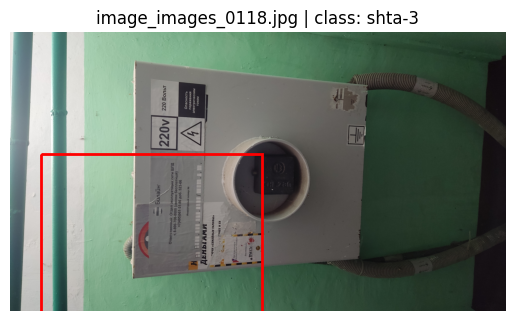

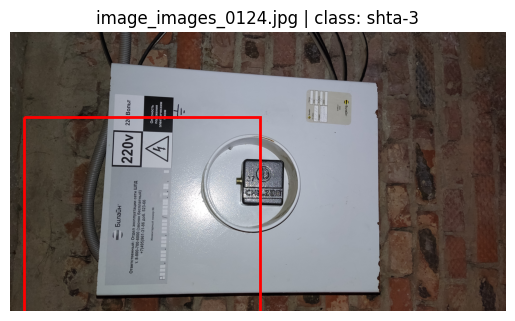

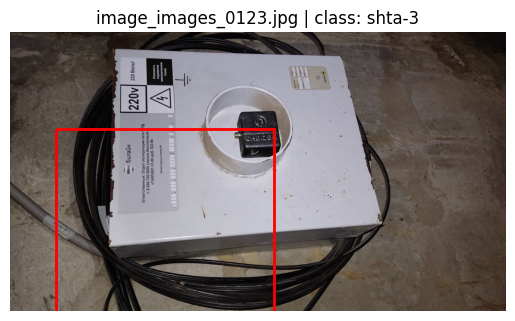

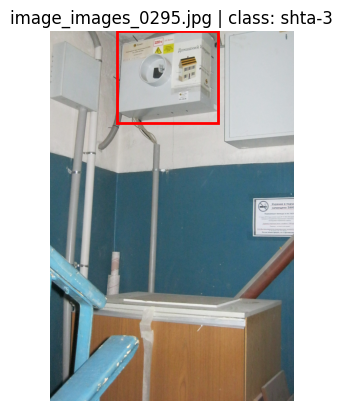

In [29]:
show_bbox(invalid, num_images=5)

По указанным примерам наблюдаем не корректные BB

Проведем проверку, при необходимости исключим данные фотографии

In [30]:
show_bbox(large_boxes, num_images=8)

Output hidden; open in https://colab.research.google.com to view.

На этих примерах наблюдаем фотографии где из-за ракурса съемки BB занимает всю площадь фотографии не охватывая при этом весь исследуемый элемент

Данные фото предпочтительно удалить

# Заключение по итогам EDA

В итоге мы имеем следующие проблемы

1. в датасете не высокое количество изображений, из-за чего обучение модели может произойти недостаточно качественно
2. есть дисбалланс классов, один из типов шкафов превалирует над всеми остальными почти в 2 раза а несколько классов не достигают даже среднего значения
3. имеется незначительное количество фотографий с аномалиями которые стоит исключить из датасета


Решения будут следующими
1. для устранения проблемы недостатка фото
    - добавить объем фотографий
    - использовать аугментацию для искусственного увеличения данных
2. для устранения дисбалланса проведем сбор дополнительных данных с упором на классы незначительно представленные в текущем датасете, это действие так же решит проблему 1 с не высоким количеством изображений
3. аномальные фотографии исключим из датасета